In [12]:
import csv
import math
import shutil
import os
import traceback
import glob
from PIL import Image
import subprocess
import matplotlib.pyplot as plt


In [5]:
# fix csv

os.chmod("./csvFix.sh", 0o755)
subprocess.call("./csvFix.sh")

0

In [7]:
# init variables

dataDir = "../dane"
datasetTypes = ['train','valid','test']
column = {"class id": 0, "filepath": 1, "label" : 2, "dataset" : 3, "scientific name" : 4}

csvfile = open('../dane/birds.csv', newline='')
reader = csv.reader(csvfile, delimiter=',')

In [11]:
# fix folder names

for datasetType in datasetTypes:
    for subfolder in os.listdir(os.path.join(dataDir, datasetType)):
        
        # delete double spaces
        path = os.path.join(dataDir, datasetType, subfolder)
        fixedpath = os.path.join(dataDir, datasetType, ' '.join(subfolder.split()))

        if (path != fixedpath):
            try:
                shutil.move(path, fixedpath)
            except IOError:
                traceback.print_exc()
            print(subfolder)

    # fix species name
    try:
        shutil.move(os.path.join(dataDir, datasetType, "PARAKETT AUKLET"), os.path.join(dataDir, datasetType, "PARAKEET AUKLET"))
    except IOError:
        traceback.print_exc()

In [10]:
# fix images with wrong dimensions (not 224 x 224)

for datasetType in datasetTypes:
    for path in glob.glob(os.path.join(dataDir, datasetType, "**/*.jpg"), recursive=True):
        image = Image.open(path)

        if (image.size != (224,224)):
            oldsize = image.size
            image = image.resize((224, 224))
            image.save(path)
            print(oldsize, "->", image.size, path)

In [35]:
# assign species name to id and count class instances

classIdByLabel = {}
classCounts = [0 for _ in range(525)]

csvfile.seek(0)
next(reader, None)

for row in reader:
    label = row[column["label"]] 
    classId = int(row[column["class id"]])
    
    classIdByLabel[label] = classId
    classCounts[classId] += 1

print("classIdByLabel:", classIdByLabel)
print("classCounts:", classCounts)

classIdByLabel: {'ABBOTTS BABBLER': 0, 'ABBOTTS BOOBY': 1, 'ABYSSINIAN GROUND HORNBILL': 2, 'AFRICAN CROWNED CRANE': 3, 'AFRICAN EMERALD CUCKOO': 4, 'AFRICAN FIREFINCH': 5, 'AFRICAN OYSTER CATCHER': 6, 'AFRICAN PIED HORNBILL': 7, 'AFRICAN PYGMY GOOSE': 8, 'ALBATROSS': 9, 'ALBERTS TOWHEE': 10, 'ALEXANDRINE PARAKEET': 11, 'ALPINE CHOUGH': 12, 'ALTAMIRA YELLOWTHROAT': 13, 'AMERICAN AVOCET': 14, 'AMERICAN BITTERN': 15, 'AMERICAN COOT': 16, 'AMERICAN FLAMINGO': 17, 'AMERICAN GOLDFINCH': 18, 'AMERICAN KESTREL': 19, 'AMERICAN PIPIT': 20, 'AMERICAN REDSTART': 21, 'AMERICAN ROBIN': 22, 'AMERICAN WIGEON': 23, 'AMETHYST WOODSTAR': 24, 'ANDEAN GOOSE': 25, 'ANDEAN LAPWING': 26, 'ANDEAN SISKIN': 27, 'ANHINGA': 28, 'ANIANIAU': 29, 'ANNAS HUMMINGBIRD': 30, 'ANTBIRD': 31, 'ANTILLEAN EUPHONIA': 32, 'APAPANE': 33, 'APOSTLEBIRD': 34, 'ARARIPE MANAKIN': 35, 'ASHY STORM PETREL': 36, 'ASHY THRUSHBIRD': 37, 'ASIAN CRESTED IBIS': 38, 'ASIAN DOLLARD BIRD': 39, 'ASIAN GREEN BEE EATER': 40, 'ASIAN OPENBILL STORK'

6 classes have 140 pictures
1 classes have 273 pictures


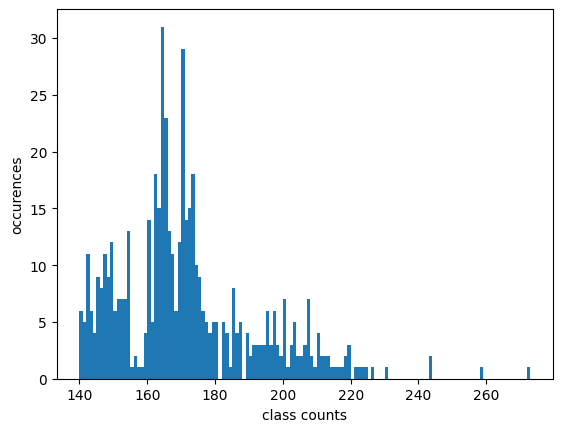

In [29]:
# make a histogram

print(sum([1 if (c == min(classCounts)) else 0 for c in classCounts]), "classes have", min(classCounts), "pictures")
print(sum([1 if (c == max(classCounts)) else 0 for c in classCounts]), "classes have", max(classCounts), "pictures")

plt.ylabel("occurences")
plt.xlabel("class counts")
plt.hist(classCounts, bins=133)

plt.show()

In [31]:
# move files around so the distribution is 70%/15%/15% for train/valid/test

movedFiles = 0
errors = 0
moveToValid = True
trainPercentage = 0.7

csvfile.seek(0)
next(reader, None)

for row in reader:
    filepath = row[column["filepath"]]
    zeroPaddedPictureNumber = filepath.split("/")[2].split(".")[0]
    maxTrainNumber = math.ceil(trainPercentage * classCounts[int(row[column["class id"]])])

    # move files from train/ to test/ and valid/ (distribute equally)
    if row[column["dataset"]] == "train":

        # if picture number > than 70% * number of this class instances
        if (int(zeroPaddedPictureNumber) > maxTrainNumber):
            destinationPath = os.path.join(dataDir, ("valid" if (moveToValid) else "test"), row[column["label"]], zeroPaddedPictureNumber + ".jpg")
            moveToValid = not moveToValid

            try:
                shutil.move(os.path.join(dataDir, filepath), destinationPath)
                movedFiles += 1
            except IOError:
                traceback.print_exc()
                errors += 1

print("moved files:", movedFiles, "errors:", errors)

moved files: 0 errors: 21500


In [32]:
# check if the percentages are correct

classCountsByDatasetType = [dict.fromkeys(datasetTypes, 0) for _ in classCounts]
errors = 0

for datasetType in datasetTypes:
    for label in classIdByLabel.keys():
        try:
            classCountsByDatasetType[classIdByLabel[label]][datasetType] = len(os.listdir(os.path.join(dataDir, datasetType, label)))
        except FileNotFoundError:
            errors += 1

print("errors:", errors)

print("label".ljust(30) + ' '.join([s.ljust(10) for s in datasetTypes]) + "lost count")
for label in classIdByLabel.keys():
    print(label.ljust(30) + ' '.join(["{:.2f}".format(count*100/classCounts[classIdByLabel[label]]).ljust(10) for count in classCountsByDatasetType[classIdByLabel[label]].values()]) + str(classCounts[classIdByLabel[label]] - sum([count for count in classCountsByDatasetType[classIdByLabel[label]].values()])))


errors: 0
label                         train      valid      test      lost count
ABBOTTS BABBLER               70.52      15.03      14.45     0
ABBOTTS BOOBY                 70.00      14.74      15.26     0
ABYSSINIAN GROUND HORNBILL    70.37      14.81      14.81     0
AFRICAN CROWNED CRANE         70.34      15.17      14.48     0
AFRICAN EMERALD CUCKOO        70.12      14.63      15.24     0
AFRICAN FIREFINCH             70.07      14.97      14.97     0
AFRICAN OYSTER CATCHER        70.30      15.15      14.55     0
AFRICAN PIED HORNBILL         70.05      14.72      15.23     0
AFRICAN PYGMY GOOSE           70.37      14.81      14.81     0
ALBATROSS                     70.42      14.79      14.79     0
ALBERTS TOWHEE                70.18      15.20      14.62     0
ALEXANDRINE PARAKEET          69.71      14.86      15.43     0
ALPINE CHOUGH                 70.45      14.77      14.77     0
ALTAMIRA YELLOWTHROAT         70.00      15.00      15.00     0
AMERICAN AVOCET      

In [33]:
# check number of classes in each dir

for datasetType in datasetTypes:
    print(datasetType, len(os.listdir(os.path.join(dataDir, datasetType))))

train 525
valid 525
test 525
